In [3]:
# Python Standard Libraries
import os

# Python Scientific Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics.pairwise import euclidean_distances

# Config
sns.set_style('white')
sns.set_context('paper')

pd.set_option('display.max_columns', 40)

%matplotlib inline

In [5]:
tidy = pd.read_csv('../../src/tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)
tidy['Num Dif'] = tidy['Num Pieces (final)'] - tidy['Num Pieces']
tidy['Type II Error Rate'] = tidy['Type II Errors'] / tidy['Num Pieces']

groups = tidy.groupby('Subject ID')

def mean_correct(df):
    return (df[['Response Time']] - df['Response Time'].mean()) / df['Response Time'].std()

tidy['Corrected Response Time'] = groups.apply(mean_correct)

In [6]:
vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [7]:
reaction_time_df = tidy.pivot_table(index='Subject ID', 
                                    values=['Response Time', 'Type II Error Rate'], 
                                    aggfunc=np.mean)

reaction_time_df['Condition'] = reaction_time_df.index.map(
    lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0]
)

reaction_time_df.head()

,Response Time,Type II Error Rate,Condition
Subject ID,,,
1455888279254,43.975740,0.301904,Trained
1455896400640,17.160010,0.229159,Trained
1455905621344,17.292635,0.071440,Trained
1455913823185,16.284312,0.218968,Trained
1455999209774,11.836917,0.203749,Trained


Optimization terminated successfully.
         Current function value: 0.452095
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     Type II Error Rate   No. Observations:                   38
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Feb 2019   Pseudo R-squ.:                     inf
Time:                        15:45:25   Log-Likelihood:                -17.180
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1142      0.983     -1.133      0.257      -3.042       0.813
Response Time    -0.

/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


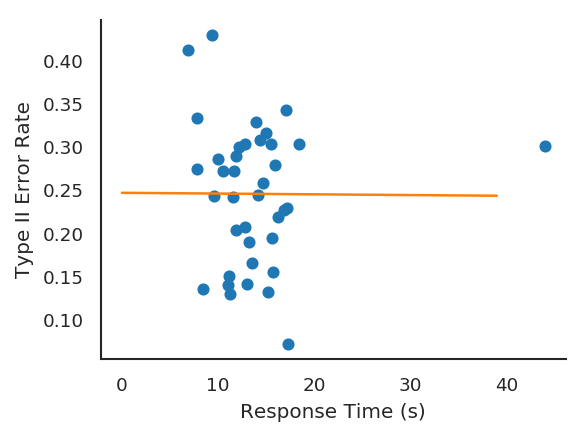

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=150)

# outlier_filter = reaction_time_df['Response Time'] <= (reaction_time_df['Response Time'].mean() + 3 * reaction_time_df['Response Time'].std())
# x = reaction_time_df.loc[outlier_filter, 'Response Time'].values
# y = reaction_time_df.loc[outlier_filter, 'Type II Error Rate'].values

x = reaction_time_df['Response Time']
y = reaction_time_df['Type II Error Rate']
axes.plot(x, y, marker='o', linestyle='none')

x_ = sm.add_constant(x)
model = sm.Logit(y, x_)
result = model.fit()
print(result.summary())

model_support = sm.add_constant(np.arange(0, 40))
model_prediction = model.predict(result.params, model_support)
axes.plot(model_support[:, 1], model_prediction)

plt.setp(axes, xlabel='Response Time (s)', ylabel='Type II Error Rate')
sns.despine()